In [1]:
# Last mod: FA 2023 Jul 27 - implemented warning flags

# Predicting ages from spectroscopic abundances with XGBoost 

In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import colors

import astropy.table
from astropy.table import Table, Column, MaskedColumn 
from scipy.stats import gaussian_kde
from scipy.interpolate import make_interp_spline

import os.path

from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

import xgboost as xgb
import shap

from itertools import product
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from utils import running_median, overplot_trend

mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15) 
font = {'family' : 'serif', 'serif': 'helvet', 'weight' : 'bold', 'size'   : 20}
mpl.rc('font', **font)
mpl.rc('text', usetex=True)

In [3]:
xgb.__version__

'2.0.0-dev'

In [3]:
suffix = "_230711" # date

# Import the training table (APOGEE-Kepler dataset)

We use the table containing asteroseismic+spectroscopic age estimates from [Miglio et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..85M/abstract) - crossmatched with APOGEE DR17:

In [4]:
miglio2021 = Table.read("../data/Miglio2021_X_APOGEE_DR17.fits")
names = [name for name in miglio2021.colnames if len(miglio2021[name].shape) <= 1]
miglio2021.keep_columns(names)
mig = miglio2021.to_pandas()
mig.head()

,APOGEE,KIC,Jmag,Hmag,Ksmag,RAdeg,DEdeg,__Fe_H_,__alpha_M_,Age,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'2M19222920+3710285',1569842,9.589,9.074,8.989,290.6217,37.174599,-0.24,0.12,9.8,...,0.012334,0,NaN,NaN,0.005112,2,0.096240,0.151900,0.069591,0
1,b'2M19300513+3717470',1726291,11.206,10.679,10.547,292.5214,37.296398,-0.34,0.19,10.1,...,0.015864,0,NaN,NaN,0.009413,2,-0.318970,-0.263310,0.085400,0
2,b'2M19045380+3741230',2283721,11.266,10.709,10.590,286.2242,37.689701,-0.19,0.11,9.4,...,0.014437,0,NaN,NaN,NaN,259,0.116419,0.172079,0.077468,0
3,b'2M19060736+3740100',2284679,9.923,9.456,9.335,286.5307,37.669399,-0.45,0.21,11.2,...,0.014171,0,NaN,NaN,0.010622,2,-0.313170,-0.257510,0.076819,0
4,b'2M19280882+3736381',2305590,9.829,9.235,9.128,292.0368,37.610600,-0.30,0.24,10.2,...,0.018914,0,NaN,NaN,0.009991,258,0.581840,0.637500,0.082008,0


In [5]:
list(mig.columns)

['APOGEE',
 'KIC',
 'Jmag',
 'Hmag',
 'Ksmag',
 'RAdeg',
 'DEdeg',
 '__Fe_H_',
 '__alpha_M_',
 'Age',
 'b_Age',
 'b_age_lc',
 'Mass',
 'b_Mass',
 'b_mass_lc',
 'Rad',
 'b_Rad',
 'b_rad_lc',
 'Dist',
 'b_Dist',
 'b_dist_lc',
 'Av',
 'b_Av',
 'b_av_lc',
 'evstate',
 'zmax',
 'e_zmax',
 'Ecc',
 'e_Ecc',
 'Rperi',
 'e_Rperi',
 'Rap',
 'e_Rap',
 'GalR',
 'Galphi',
 'GalZ',
 'vR',
 'vT',
 'vZ',
 '_RA',
 '_DE',
 'APOGEE_ID',
 'TELESCOPE',
 'FIELD',
 'ALT_ID',
 'RA',
 'DEC',
 'GLON',
 'GLAT',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'AK_TARG',
 'AK_TARG_METHOD',
 'AK_WISE',
 'SFD_EBV',
 'APOGEE_TARGET1',
 'APOGEE_TARGET2',
 'APOGEE2_TARGET1',
 'APOGEE2_TARGET2',
 'APOGEE2_TARGET3',
 'APOGEE2_TARGET4',
 'TARGFLAGS',
 'SURVEY',
 'PROGRAMNAME',
 'NVISITS',
 'SNR',
 'SNREV',
 'STARFLAG',
 'STARFLAGS',
 'ANDFLAG',
 'ANDFLAGS',
 'VHELIO_AVG',
 'VSCATTER',
 'VERR',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_ALPHA',
 'RV_CARB',
 'RV_CHI2',
 'RV_CCFWHM',
 'RV_AUTOFWHM',
 'RV_FLAG',
 'N_COMPONENTS'

There is also a column informing about the evolutionary state (RC / RGB):

In [6]:
print("RGB stars:", np.sum(mig['evstate']==1))
print("RC  stars:", np.sum(mig['evstate']==2))
print("unidentified:", np.sum((mig['evstate']!=1) & (mig['evstate']!=2)))

RGB stars: 2428
RC  stars: 887
unidentified: 0


We'll also have a look at the APOGEE DR17 abundance flags:

In [7]:
for columns in mig:
    if columns.endswith("_FLAG"):
        print(columns)
        print(mig[str(columns)].value_counts())
        print()

RV_FLAG
0     3314
32       1
Name: RV_FLAG, dtype: int64

C_FE_FLAG
0      3314
256       1
Name: C_FE_FLAG, dtype: int64

CI_FE_FLAG
0      3312
256       3
Name: CI_FE_FLAG, dtype: int64

N_FE_FLAG
0      3272
256      37
288       6
Name: N_FE_FLAG, dtype: int64

O_FE_FLAG
0    3315
Name: O_FE_FLAG, dtype: int64

NA_FE_FLAG
0      3311
256       3
1         1
Name: NA_FE_FLAG, dtype: int64

MG_FE_FLAG
0    3315
Name: MG_FE_FLAG, dtype: int64

AL_FE_FLAG
0    3315
Name: AL_FE_FLAG, dtype: int64

SI_FE_FLAG
0    3315
Name: SI_FE_FLAG, dtype: int64

P_FE_FLAG
2      3270
258      30
0         8
3         4
259       3
Name: P_FE_FLAG, dtype: int64

S_FE_FLAG
0      3314
256       1
Name: S_FE_FLAG, dtype: int64

K_FE_FLAG
0      3313
1         1
256       1
Name: K_FE_FLAG, dtype: int64

CA_FE_FLAG
0    3315
Name: CA_FE_FLAG, dtype: int64

TI_FE_FLAG
0    3315
Name: TI_FE_FLAG, dtype: int64

TIII_FE_FLAG
0      3307
257       4
256       3
1         1
Name: TIII_FE_FLAG, dtype: int64


## Data selection criteria

Looking at the FLAG values above, we decide not to use [P/Fe] and [Cu/Fe].
For all other abundances, we require the corresponding FLAG to equal zero:

In [8]:
mig = mig[(mig['RV_FLAG'] == 0)   & (mig['C_FE_FLAG'] == 0)   & \
          (mig['CI_FE_FLAG'] == 0)& (mig['N_FE_FLAG'] == 0)   & \
          (mig['O_FE_FLAG'] == 0) & (mig['NA_FE_FLAG'] == 0)  & \
          (mig['S_FE_FLAG'] == 0) & (mig['TI_FE_FLAG'] == 0)  & \
          (mig['V_FE_FLAG'] == 0) & (mig['CE_FE_FLAG'] == 0)  & \
          (mig['SNREV'] >= 70) & \
          (0.5 * (mig['b_age_lc'] - mig['b_Age']) / mig["Age"] < 0.3) & \
          (0.5 * (mig['b_age_lc'] - mig['b_Age']) < 3) & \
          (mig["Age"] > 0)    & (mig["Age"] < 15) & \
          (mig["ALPHA_M"] < 0.14 + 0.0001*(mig["Age"] - 4.1)**5)
         ]

In [9]:
print(len(mig), "suffice the FLAG conditions")

3060 suffice the FLAG conditions


(array([  2.,   5.,  20., 135., 366., 616., 891., 710., 262.,  53.]),
 array([-0.94691998, -0.80627298, -0.66562599, -0.524979  , -0.384332  ,
        -0.24368499, -0.103038  ,  0.037609  ,  0.17825601,  0.318903  ,
         0.45954999]),
 <BarContainer object of 10 artists>)

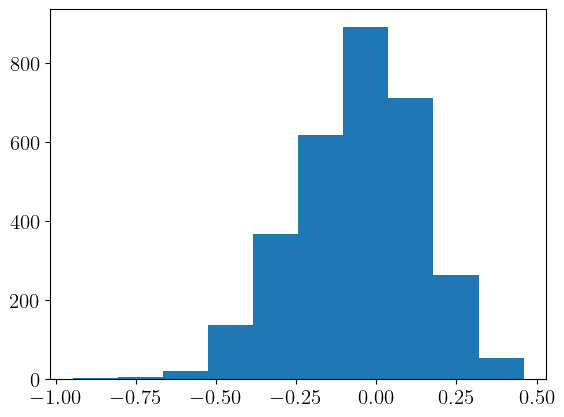

In [10]:
plt.hist(mig["FE_H"])

## Some plots (overplotting the training set over the full APOGEE DR17 data):

The APOGEE DR17 allStar file is big, so it's not included in the data folder. Even the "light" version is 1.7 GB:
* Data model: https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStar.html
* "Lite" file for download: https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits

The following cell reads the DR17 table:

In [11]:
apogee_data = "../data/allStarLite-dr17-synspec_rev1.fits"

if os.path.exists(apogee_data):
    pass
else:
    # Download the APOGEE DR17 "lite" version: (this can take a while...)
    os.system('wget https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits')
    os.system('mv allStarLite-dr17-synspec_rev1.fits ../data/.')

# Read and convert to pandas
apogee_dr17 = Table.read(apogee_data)
names = [name for name in apogee_dr17.colnames if len(apogee_dr17[name].shape) <= 1]
apogee_dr17.keep_columns(names)
big   = apogee_dr17.to_pandas()

print('Number of rows: ' +str(len(big)))
big.head()

Number of rows: 733901


,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'VESTA',b'apo1m',b'calibration',b' ',NaN,NaN,292.219131,-30.602919,99.999001,0.000,...,0.010266,0,NaN,NaN,0.059403,2,NaN,NaN,NaN,64
1,b'2M00000002+7417074',b'apo25m',b'120+12',b'none',0.000103,74.285408,119.401807,11.767414,8.597000,0.039,...,0.010609,0,NaN,NaN,0.001221,2,NaN,NaN,NaN,64
2,b'2M00000019-1924498',b'apo25m',b'060-75',b'none',0.000832,-19.413851,63.394122,-75.906397,11.074000,0.022,...,0.013835,0,NaN,NaN,0.102594,2,NaN,NaN,NaN,64
3,b'2M00000032+5737103',b'apo25m',b'116-04',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.016555,0,NaN,NaN,0.123839,2,NaN,NaN,NaN,64
4,b'2M00000032+5737103',b'apo25m',b'N7789',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.012638,0,NaN,NaN,0.107103,2,NaN,NaN,NaN,64


Define the same selection as for the training set:

In [42]:
# Cut out stars on the RGB close to the training set
kielbox =  (big['LOGG'] < 3.4)  & (big['LOGG'] > 2.2) & (big['TEFF'] < 5200) & (big['TEFF'] > 4400)
# IF you want to be more restrictive, add:
# & (big['LOGG'] < -7 + 0.0022*big['TEFF'])  & (big['LOGG'] > -8.6 + 0.0022*big['TEFF'])

selection = kielbox  & \
            (big['FE_H'] > -1)      & (big['SNREV'] >= 50)    & \
            (big['TEFF_ERR'] < 150) & (big['RV_FLAG'] == 0)   & \
            (big['C_FE_FLAG'] == 0) & (big['N_FE_FLAG'] == 0) & \
            (big['CI_FE_FLAG'] == 0)& (big['O_FE_FLAG'] == 0) & \
            (big['SI_FE_FLAG'] == 0)& (big['TI_FE_FLAG'] == 0)& \
            (big['CA_FE_FLAG'] == 0)& (big['AL_FE_FLAG'] == 0)& \
            (big['CO_FE_FLAG'] == 0)& (big['NI_FE_FLAG'] == 0)& \
            (big['MN_FE_FLAG'] == 0)& (big['CE_FE_FLAG'] == 0)

print(np.sum(selection), "stars with good quality")

193886 stars with good quality


### $T_{\rm eff}-\log g$ diagram

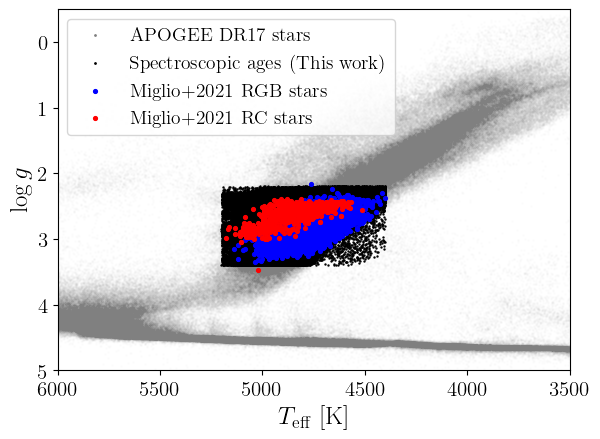

In [43]:
rgb = (mig['evstate']==1)
rc  = (mig['evstate']==2)

plt.scatter(big['TEFF'], big['LOGG'], c="grey", alpha=0.01, s=1, label="_nolabel")
plt.scatter(-999, -999, c="grey", alpha=1, s=1, label="APOGEE DR17 stars")
plt.scatter(big['TEFF'][selection], big['LOGG'][selection], c="k", s=.5, label="_nolabel")
plt.scatter(-999, -999, c="k", alpha=1, s=1, label="Spectroscopic ages (This work)")
plt.scatter(mig['TEFF'][rgb], mig['LOGG'][rgb], s=7.5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['TEFF'][rc],  mig['LOGG'][rc],  s=7.5, c="red", label="Miglio+2021 RC stars")
plt.axis([6000, 3500, 5, -0.5])
plt.xlabel(r"$T_{\rm eff}$ [K]", fontsize=18)
plt.ylabel(r"$\log g$", fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.tight_layout()
plt.savefig("../im/kiel_diagram.png", dpi=300)

### Age uncertainties of the Miglio+2021 sample

Median rel. age uncertainty for RGB: 0.22727272
Median rel. age uncertainty for RC: 0.097561


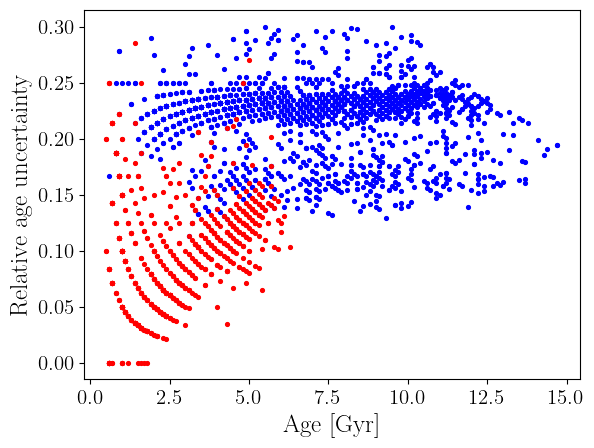

In [16]:
x = mig['Age']
y = 0.5 * (mig['b_age_lc'] - mig['b_Age']) / mig["Age"]

plt.scatter(x[rgb],y[rgb], c="b", s=7.5)
plt.scatter(x[rc], y[rc],  c="r", s=7.5)

plt.xlabel(r"Age [Gyr]", fontsize=18)
plt.ylabel(r"Relative age uncertainty", fontsize=18)
plt.savefig("../im/age_uncerts_training.png", dpi=300)

print("Median rel. age uncertainty for RGB:", np.nanmedian(y[rgb]))
print("Median rel. age uncertainty for RC:", np.nanmedian(y[rc]))
      

## Galactic distribution

In [17]:
dr17_master = Table.read("/home/friedel/Astro/Spectro/APOGEE/data/DR17/APOGEE_DR17_MASTER_Mar2023.fits")
chem_age = np.isfinite(dr17_master['spec_age_230711'])

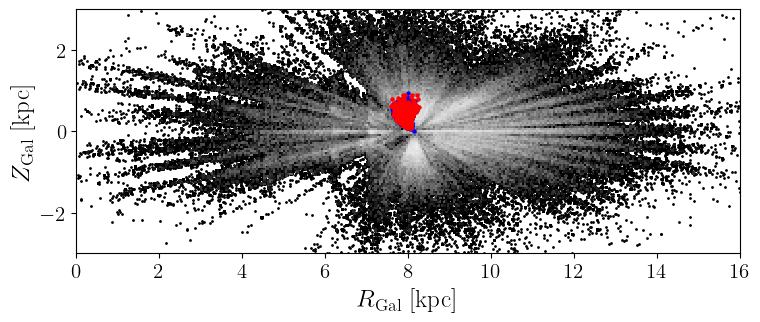

In [22]:
f = plt.figure(figsize=(8,3.7))
plt.scatter(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], c="k", s=1, alpha=1, label="APOGEE DR17")
Ht,X1,X2 = np.histogram2d(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], 
                          bins=[320,120], range=[[0, 16], [-3, 3]])
Ht[Ht<2] = np.nan
image = plt.pcolor(0.5*(X1[:-1]+X1[1:]), 0.5*(X2[:-1]+X2[1:]), Ht.T, cmap="Greys_r", 
                   label=r"APOGEE DR17 giants", norm=colors.LogNorm())
plt.scatter(mig['GalR'][rgb], mig['GalZ'][rgb], s=5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['GalR'][rc],  mig['GalZ'][rc],  s=5, c="red", label="Miglio+2021 RC stars")
plt.axis([0, 16, -3, 3])
plt.xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
plt.ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)
plt.tight_layout()
plt.savefig("../im/RZ_training_vs_all.png", dpi=300)

# Create the actual training set

Now we create a pandas dataframe containing only the columns we think could be interesting to use in the training:

In [23]:
trainfeatures = ['TEFF', 'LOGG', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 
                 'NA_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'K_FE', 
                 'CA_FE', 'TI_FE', 'V_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'CE_FE']
filtered_df = mig[['Age'] + trainfeatures].copy() # excluding: ['FE_H']
filtered_df = filtered_df.dropna()
filtered_df = filtered_df.apply(pd.to_numeric, errors='coerce')

In [24]:
filtered_df.head()

,Age,TEFF,LOGG,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,K_FE,CA_FE,TI_FE,V_FE,MN_FE,CO_FE,NI_FE,CE_FE
0,9.8,4817.990723,3.083905,0.071996,0.076009,0.073346,0.196913,-0.129988,0.223263,0.188314,0.134081,0.235769,0.094765,0.179623,-0.042288,-0.101498,0.09864,0.107133,0.096240
1,10.1,4823.796387,3.109932,0.070293,0.194000,0.115990,0.314393,-0.352128,0.348673,0.259540,0.198561,0.302629,0.190765,0.151823,0.250612,-0.122728,0.13715,0.110182,-0.318970
2,9.4,4748.026855,2.788529,0.065446,0.029532,0.086760,0.180403,0.009112,0.186943,0.195936,0.124651,0.368155,0.109715,0.109363,-0.187218,-0.096728,0.11898,0.042022,0.116419
3,11.2,4889.548828,3.245908,0.102185,0.198900,0.009152,0.328173,0.068522,0.361593,0.247761,0.191911,0.361549,0.191585,0.183673,-0.175608,-0.144048,0.08713,0.081733,-0.313170
4,10.2,4605.007812,2.480893,0.166720,0.234920,0.034750,0.282853,0.043942,0.394983,0.272437,0.166551,0.411468,0.190875,0.281993,-0.025298,-0.137478,0.19849,0.095583,0.581840


In [25]:
# Split dataframe into input and output columns
y = filtered_df['Age']
X = filtered_df.drop(columns = 'Age')

# Splitting into train and test (80% vs 20%)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Setup XGBoost quantile regression

Using the new functionality in xgboost v2.0.0; following the tutorial [here](https://xgboost.readthedocs.io/en/latest/python/examples/quantile_regression.html#sphx-glr-python-examples-quantile-regression-py).

[0]	Train-quantile:1.25155	Test-quantile:1.28157
[1]	Train-quantile:1.24426	Test-quantile:1.27473
[2]	Train-quantile:1.23700	Test-quantile:1.26764
[3]	Train-quantile:1.22978	Test-quantile:1.26077
[4]	Train-quantile:1.22252	Test-quantile:1.25375
[5]	Train-quantile:1.21548	Test-quantile:1.24696
[6]	Train-quantile:1.20856	Test-quantile:1.24016
[7]	Train-quantile:1.20167	Test-quantile:1.23333
[8]	Train-quantile:1.19480	Test-quantile:1.22694
[9]	Train-quantile:1.18790	Test-quantile:1.22028
[10]	Train-quantile:1.18114	Test-quantile:1.21373
[11]	Train-quantile:1.17454	Test-quantile:1.20725
[12]	Train-quantile:1.16791	Test-quantile:1.20088
[13]	Train-quantile:1.16137	Test-quantile:1.19453
[14]	Train-quantile:1.15476	Test-quantile:1.18815
[15]	Train-quantile:1.14821	Test-quantile:1.18184
[16]	Train-quantile:1.14166	Test-quantile:1.17564
[17]	Train-quantile:1.13537	Test-quantile:1.16956
[18]	Train-quantile:1.12910	Test-quantile:1.16351
[19]	Train-quantile:1.12286	Test-quantile:1.15729
[20]	Train

[163]	Train-quantile:0.56504	Test-quantile:0.61233
[164]	Train-quantile:0.56286	Test-quantile:0.61007
[165]	Train-quantile:0.56066	Test-quantile:0.60780
[166]	Train-quantile:0.55846	Test-quantile:0.60546
[167]	Train-quantile:0.55633	Test-quantile:0.60326
[168]	Train-quantile:0.55415	Test-quantile:0.60103
[169]	Train-quantile:0.55203	Test-quantile:0.59878
[170]	Train-quantile:0.54994	Test-quantile:0.59665
[171]	Train-quantile:0.54783	Test-quantile:0.59454
[172]	Train-quantile:0.54579	Test-quantile:0.59239
[173]	Train-quantile:0.54370	Test-quantile:0.59029
[174]	Train-quantile:0.54165	Test-quantile:0.58824
[175]	Train-quantile:0.53973	Test-quantile:0.58625
[176]	Train-quantile:0.53766	Test-quantile:0.58422
[177]	Train-quantile:0.53563	Test-quantile:0.58218
[178]	Train-quantile:0.53365	Test-quantile:0.58020
[179]	Train-quantile:0.53166	Test-quantile:0.57818
[180]	Train-quantile:0.52974	Test-quantile:0.57625
[181]	Train-quantile:0.52782	Test-quantile:0.57441
[182]	Train-quantile:0.52592	Te

[324]	Train-quantile:0.34983	Test-quantile:0.40485
[325]	Train-quantile:0.34904	Test-quantile:0.40424
[326]	Train-quantile:0.34832	Test-quantile:0.40363
[327]	Train-quantile:0.34760	Test-quantile:0.40302
[328]	Train-quantile:0.34688	Test-quantile:0.40242
[329]	Train-quantile:0.34617	Test-quantile:0.40189
[330]	Train-quantile:0.34545	Test-quantile:0.40131
[331]	Train-quantile:0.34471	Test-quantile:0.40064
[332]	Train-quantile:0.34400	Test-quantile:0.40015
[333]	Train-quantile:0.34329	Test-quantile:0.39956
[334]	Train-quantile:0.34256	Test-quantile:0.39893
[335]	Train-quantile:0.34182	Test-quantile:0.39834
[336]	Train-quantile:0.34107	Test-quantile:0.39773
[337]	Train-quantile:0.34035	Test-quantile:0.39716
[338]	Train-quantile:0.33968	Test-quantile:0.39656
[339]	Train-quantile:0.33902	Test-quantile:0.39606
[340]	Train-quantile:0.33831	Test-quantile:0.39557
[341]	Train-quantile:0.33759	Test-quantile:0.39498
[342]	Train-quantile:0.33690	Test-quantile:0.39451
[343]	Train-quantile:0.33630	Te

[645]	Train-quantile:0.23650	Test-quantile:0.32990
[646]	Train-quantile:0.23636	Test-quantile:0.32980
[647]	Train-quantile:0.23623	Test-quantile:0.32973
[648]	Train-quantile:0.23608	Test-quantile:0.32968
[649]	Train-quantile:0.23594	Test-quantile:0.32963
[650]	Train-quantile:0.23577	Test-quantile:0.32955
[651]	Train-quantile:0.23565	Test-quantile:0.32953
[652]	Train-quantile:0.23553	Test-quantile:0.32950
[653]	Train-quantile:0.23539	Test-quantile:0.32942
[654]	Train-quantile:0.23525	Test-quantile:0.32940
[655]	Train-quantile:0.23509	Test-quantile:0.32936
[656]	Train-quantile:0.23495	Test-quantile:0.32925
[657]	Train-quantile:0.23483	Test-quantile:0.32923
[658]	Train-quantile:0.23469	Test-quantile:0.32911
[659]	Train-quantile:0.23457	Test-quantile:0.32907
[660]	Train-quantile:0.23444	Test-quantile:0.32899
[661]	Train-quantile:0.23432	Test-quantile:0.32894
[662]	Train-quantile:0.23421	Test-quantile:0.32891
[663]	Train-quantile:0.23410	Test-quantile:0.32889
[664]	Train-quantile:0.23394	Te

[806]	Train-quantile:0.21882	Test-quantile:0.32281
[807]	Train-quantile:0.21873	Test-quantile:0.32279
[808]	Train-quantile:0.21867	Test-quantile:0.32277
[809]	Train-quantile:0.21859	Test-quantile:0.32275
[810]	Train-quantile:0.21850	Test-quantile:0.32275
[811]	Train-quantile:0.21839	Test-quantile:0.32267
[812]	Train-quantile:0.21831	Test-quantile:0.32265
[813]	Train-quantile:0.21822	Test-quantile:0.32264
[814]	Train-quantile:0.21812	Test-quantile:0.32262
[815]	Train-quantile:0.21807	Test-quantile:0.32263
[816]	Train-quantile:0.21799	Test-quantile:0.32261
[817]	Train-quantile:0.21791	Test-quantile:0.32261
[818]	Train-quantile:0.21784	Test-quantile:0.32253
[819]	Train-quantile:0.21775	Test-quantile:0.32247
[820]	Train-quantile:0.21767	Test-quantile:0.32246
[821]	Train-quantile:0.21760	Test-quantile:0.32246
[822]	Train-quantile:0.21751	Test-quantile:0.32243
[823]	Train-quantile:0.21739	Test-quantile:0.32243
[824]	Train-quantile:0.21732	Test-quantile:0.32242
[825]	Train-quantile:0.21723	Te

[967]	Train-quantile:0.20663	Test-quantile:0.31999
[968]	Train-quantile:0.20657	Test-quantile:0.32002
[969]	Train-quantile:0.20651	Test-quantile:0.31999
[970]	Train-quantile:0.20644	Test-quantile:0.31997
[971]	Train-quantile:0.20638	Test-quantile:0.31995
[972]	Train-quantile:0.20633	Test-quantile:0.31995
[973]	Train-quantile:0.20627	Test-quantile:0.31993
[974]	Train-quantile:0.20620	Test-quantile:0.31995
[975]	Train-quantile:0.20613	Test-quantile:0.31997
[976]	Train-quantile:0.20607	Test-quantile:0.31996
[977]	Train-quantile:0.20601	Test-quantile:0.31992
[978]	Train-quantile:0.20596	Test-quantile:0.31991
[979]	Train-quantile:0.20585	Test-quantile:0.31992
[980]	Train-quantile:0.20578	Test-quantile:0.31989
[981]	Train-quantile:0.20568	Test-quantile:0.31988
[982]	Train-quantile:0.20560	Test-quantile:0.31987
[983]	Train-quantile:0.20554	Test-quantile:0.31988
[984]	Train-quantile:0.20545	Test-quantile:0.31988
[985]	Train-quantile:0.20538	Test-quantile:0.31987
[986]	Train-quantile:0.20531	Te

[145]	Train-rmse:1.80832	Test-rmse:1.82806
[146]	Train-rmse:1.80251	Test-rmse:1.82294
[147]	Train-rmse:1.79673	Test-rmse:1.81793
[148]	Train-rmse:1.79101	Test-rmse:1.81266
[149]	Train-rmse:1.78532	Test-rmse:1.80781
[150]	Train-rmse:1.77977	Test-rmse:1.80276
[151]	Train-rmse:1.77425	Test-rmse:1.79793
[152]	Train-rmse:1.76891	Test-rmse:1.79277
[153]	Train-rmse:1.76350	Test-rmse:1.78771
[154]	Train-rmse:1.75809	Test-rmse:1.78281
[155]	Train-rmse:1.75250	Test-rmse:1.77779
[156]	Train-rmse:1.74709	Test-rmse:1.77294
[157]	Train-rmse:1.74160	Test-rmse:1.76809
[158]	Train-rmse:1.73616	Test-rmse:1.76305
[159]	Train-rmse:1.73090	Test-rmse:1.75842
[160]	Train-rmse:1.72564	Test-rmse:1.75377
[161]	Train-rmse:1.72057	Test-rmse:1.74902
[162]	Train-rmse:1.71528	Test-rmse:1.74441
[163]	Train-rmse:1.71010	Test-rmse:1.74021
[164]	Train-rmse:1.70506	Test-rmse:1.73549
[165]	Train-rmse:1.69995	Test-rmse:1.73090
[166]	Train-rmse:1.69480	Test-rmse:1.72653
[167]	Train-rmse:1.68960	Test-rmse:1.72193
[168]	Train

[336]	Train-rmse:1.12383	Test-rmse:1.25536
[337]	Train-rmse:1.12159	Test-rmse:1.25359
[338]	Train-rmse:1.11963	Test-rmse:1.25220
[339]	Train-rmse:1.11752	Test-rmse:1.25088
[340]	Train-rmse:1.11553	Test-rmse:1.24953
[341]	Train-rmse:1.11364	Test-rmse:1.24822
[342]	Train-rmse:1.11155	Test-rmse:1.24681
[343]	Train-rmse:1.10957	Test-rmse:1.24528
[344]	Train-rmse:1.10750	Test-rmse:1.24417
[345]	Train-rmse:1.10572	Test-rmse:1.24289
[346]	Train-rmse:1.10377	Test-rmse:1.24119
[347]	Train-rmse:1.10175	Test-rmse:1.23961
[348]	Train-rmse:1.09997	Test-rmse:1.23839
[349]	Train-rmse:1.09811	Test-rmse:1.23694
[350]	Train-rmse:1.09618	Test-rmse:1.23577
[351]	Train-rmse:1.09432	Test-rmse:1.23445
[352]	Train-rmse:1.09252	Test-rmse:1.23324
[353]	Train-rmse:1.09076	Test-rmse:1.23186
[354]	Train-rmse:1.08892	Test-rmse:1.23059
[355]	Train-rmse:1.08700	Test-rmse:1.22936
[356]	Train-rmse:1.08507	Test-rmse:1.22779
[357]	Train-rmse:1.08313	Test-rmse:1.22660
[358]	Train-rmse:1.08120	Test-rmse:1.22564
[359]	Train

[527]	Train-rmse:0.86951	Test-rmse:1.10618
[528]	Train-rmse:0.86881	Test-rmse:1.10591
[529]	Train-rmse:0.86799	Test-rmse:1.10548
[530]	Train-rmse:0.86713	Test-rmse:1.10507
[531]	Train-rmse:0.86639	Test-rmse:1.10489
[532]	Train-rmse:0.86556	Test-rmse:1.10441
[533]	Train-rmse:0.86462	Test-rmse:1.10404
[534]	Train-rmse:0.86373	Test-rmse:1.10376
[535]	Train-rmse:0.86294	Test-rmse:1.10371
[536]	Train-rmse:0.86222	Test-rmse:1.10342
[537]	Train-rmse:0.86135	Test-rmse:1.10305
[538]	Train-rmse:0.86063	Test-rmse:1.10275
[539]	Train-rmse:0.85961	Test-rmse:1.10234
[540]	Train-rmse:0.85893	Test-rmse:1.10182
[541]	Train-rmse:0.85815	Test-rmse:1.10170
[542]	Train-rmse:0.85732	Test-rmse:1.10137
[543]	Train-rmse:0.85658	Test-rmse:1.10113
[544]	Train-rmse:0.85582	Test-rmse:1.10077
[545]	Train-rmse:0.85506	Test-rmse:1.10054
[546]	Train-rmse:0.85432	Test-rmse:1.10026
[547]	Train-rmse:0.85351	Test-rmse:1.09991
[548]	Train-rmse:0.85256	Test-rmse:1.09965
[549]	Train-rmse:0.85167	Test-rmse:1.09941
[550]	Train

[718]	Train-rmse:0.75358	Test-rmse:1.07320
[719]	Train-rmse:0.75310	Test-rmse:1.07318
[720]	Train-rmse:0.75257	Test-rmse:1.07310
[721]	Train-rmse:0.75214	Test-rmse:1.07299
[722]	Train-rmse:0.75176	Test-rmse:1.07291
[723]	Train-rmse:0.75134	Test-rmse:1.07278
[724]	Train-rmse:0.75073	Test-rmse:1.07265
[725]	Train-rmse:0.75030	Test-rmse:1.07255
[726]	Train-rmse:0.74985	Test-rmse:1.07248
[727]	Train-rmse:0.74929	Test-rmse:1.07233
[728]	Train-rmse:0.74896	Test-rmse:1.07223
[729]	Train-rmse:0.74854	Test-rmse:1.07228
[730]	Train-rmse:0.74811	Test-rmse:1.07210
[731]	Train-rmse:0.74775	Test-rmse:1.07196
[732]	Train-rmse:0.74739	Test-rmse:1.07186
[733]	Train-rmse:0.74685	Test-rmse:1.07179
[734]	Train-rmse:0.74643	Test-rmse:1.07178
[735]	Train-rmse:0.74593	Test-rmse:1.07159
[736]	Train-rmse:0.74556	Test-rmse:1.07152
[737]	Train-rmse:0.74522	Test-rmse:1.07155
[738]	Train-rmse:0.74479	Test-rmse:1.07161
[739]	Train-rmse:0.74419	Test-rmse:1.07148
[740]	Train-rmse:0.74394	Test-rmse:1.07136
[741]	Train

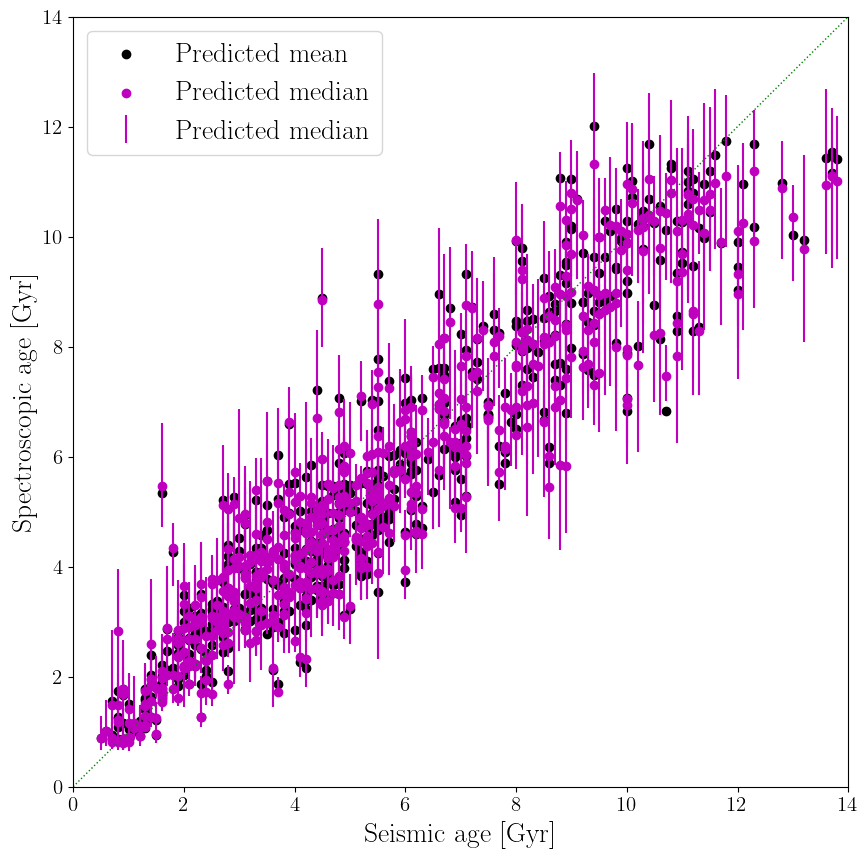

In [27]:
import argparse
from typing import Dict

def quantile_loss(X_train, X_test, y_train, y_test):
    """Train a quantile regression model."""
    # Train on 0.16 and 0.84 quantiles. The model is similar to multi-class and
    # multi-target models.
    alpha = np.array([0.16, 0.5, 0.84])
    evals_result: Dict[str, Dict] = {}

    # We will be using the `hist` tree method, quantile DMatrix can be used to preserve
    # memory.
    # Do not use the `exact` tree method for quantile regression, otherwise the
    # performance might drop.
    Xy_train = xgb.QuantileDMatrix(X_train, y_train)
    # use Xy as a reference
    Xy_test = xgb.QuantileDMatrix(X_test, y_test, ref=Xy_train)

    qbooster = xgb.train(
        {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": alpha,
            'learning_rate': 0.005,
            'max_depth': 7,
            'min_child_weight': 10,
            'nthread': 4,
            'subsample': 0.6},
        Xy_train,
        num_boost_round=1500,
        early_stopping_rounds=10,
        # The evaluation result is a weighted average across multiple quantiles.
        evals=[(Xy_train, "Train"), (Xy_test, "Test")],
        evals_result=evals_result
    )
    scores = qbooster.inplace_predict(X_test)

    y_lower = scores[:, 0]  # alpha=0.16
    y_med   = scores[:, 1]  # alpha=0.50, median
    y_upper = scores[:, 2]  # alpha=0.84

    # Train a mse model for comparison
    booster = xgb.train(
        {   "objective": "reg:squarederror",
            "tree_method": "hist",
            'learning_rate': 0.005,
            'max_depth': 7,
            'min_child_weight': 10,
            'nthread': 4,
            'subsample': 0.6},
        Xy_train,
        num_boost_round=1500,
        early_stopping_rounds=10,
        evals=[(Xy_train, "Train"), (Xy_test, "Test")],
        evals_result=evals_result,
    )
    y_pred = booster.inplace_predict(X_test)
    
    xx  = np.linspace(0,14,1000)
    fig = plt.figure(figsize=(10, 10))
    plt.plot(xx, xx, "g:", linewidth=1)
    plt.scatter(y_test, y_pred, c="k", label="Predicted mean")
    plt.scatter(y_test, y_med, c="m", label="Predicted median")
    plt.errorbar(y_test, y_med, yerr=[np.maximum(y_med-y_lower,0.), np.maximum(y_upper-y_med, 0.)], 
                 c="m", label="Predicted median", ls="none", markersize=5)

    plt.xlabel(r"Seismic age [Gyr]")
    plt.ylabel(r"Spectroscopic age [Gyr]")
    plt.axis([0,14,0,14])
    plt.legend(loc="upper left")
    plt.show()
    
    return qbooster


qbooster = quantile_loss(train_X, test_X, train_y, test_y)


# Plots

In [31]:
scores = qbooster.inplace_predict(test_X)

y_lower = scores[:, 0]  # alpha=0.16
y_med   = scores[:, 1]  # alpha=0.50, median
y_upper = scores[:, 2]  # alpha=0.84


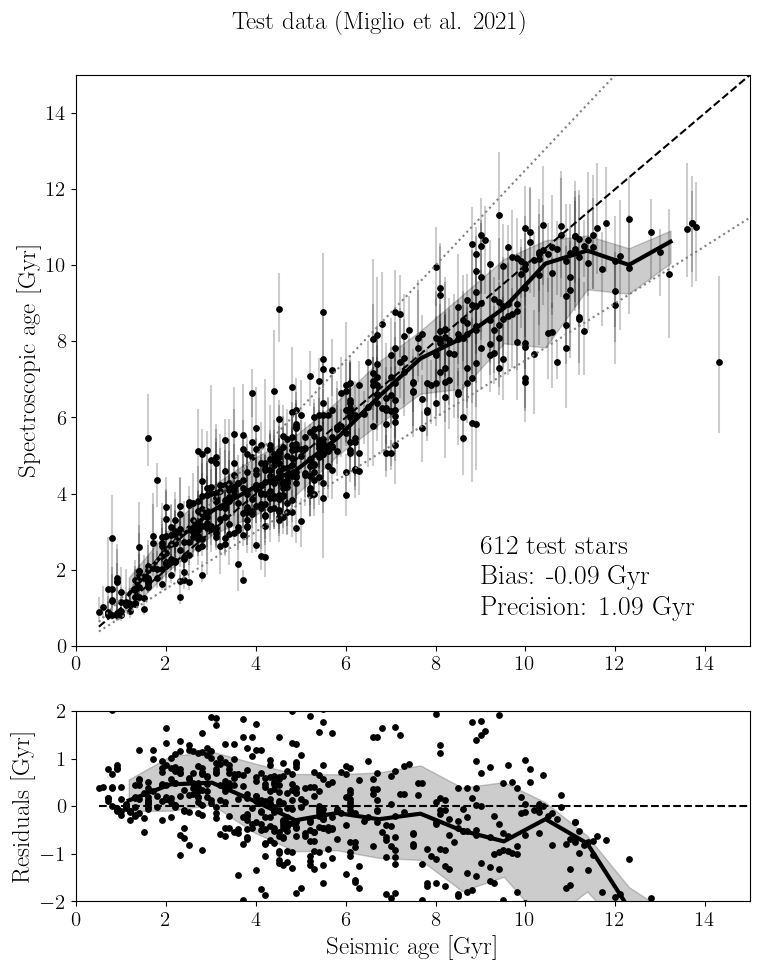

In [34]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(8,10))

# Top panel: predicted age vs. seismic age
plt.axes(a0)
a0.errorbar(test_y, y_med, yerr=[np.maximum(y_med-y_lower,0.), np.maximum(y_upper-y_med, 0.)], 
            c="k", label="none", ls="none", markersize=5, alpha=0.2)
a0.scatter(test_y, y_med, c="k", s=15, label="Default model")
overplot_trend(test_y, y_med, alpha=0.2, color="k", bins=15)
xx = np.linspace(np.min(test_y), 15, 20)
a0.plot(xx, xx, color = 'k', ls="dashed")
a0.plot(xx, 1.25*xx, color = 'grey', ls="dotted")
a0.plot(xx, 0.75*xx, color = 'grey', ls="dotted")
a0.set_ylabel(r"Spectroscopic age [Gyr]", fontsize=18)
a0.axis([0,15,0,15])

plt.text(9, 2.4, str(len(test_y))+ " test stars", fontsize=20)
plt.text(9, 1.6, "Bias: "+ str(np.round(np.mean(y_med-test_y),2))+ " Gyr", fontsize=20)
plt.text(9, 0.8, "Precision: "+ str(np.round(np.std(y_med-test_y),2))+ " Gyr", fontsize=20)

# Bottom panel: residuals
plt.axes(a1)
a1.scatter(test_y, y_med-test_y, c="k", s=15)
overplot_trend(test_y, y_med-test_y, alpha=0.2, color="k", bins=15)
a1.plot(xx, np.zeros(len(xx)), color = 'k', ls="dashed")
a1.set_xlabel(r"Seismic age [Gyr]", fontsize=18)
a1.set_ylabel(r"Residuals [Gyr]", fontsize=18)
a1.axis([0,15,-2, 2])
plt.suptitle("Test data (Miglio et al. 2021)", fontsize=18)
plt.tight_layout()
plt.savefig("../im/predicted_vs_true_testdata.png", dpi=300)

# Estimate ages for the APOGEE DR17 data:

We already read the big file above:

In [36]:
big.head()

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'VESTA',b'apo1m',b'calibration',b' ',NaN,NaN,292.219131,-30.602919,99.999001,0.000,...,0.010266,0,NaN,NaN,0.059403,2,NaN,NaN,NaN,64
1,b'2M00000002+7417074',b'apo25m',b'120+12',b'none',0.000103,74.285408,119.401807,11.767414,8.597000,0.039,...,0.010609,0,NaN,NaN,0.001221,2,NaN,NaN,NaN,64
2,b'2M00000019-1924498',b'apo25m',b'060-75',b'none',0.000832,-19.413851,63.394122,-75.906397,11.074000,0.022,...,0.013835,0,NaN,NaN,0.102594,2,NaN,NaN,NaN,64
3,b'2M00000032+5737103',b'apo25m',b'116-04',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.016555,0,NaN,NaN,0.123839,2,NaN,NaN,NaN,64
4,b'2M00000032+5737103',b'apo25m',b'N7789',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.012638,0,NaN,NaN,0.107103,2,NaN,NaN,NaN,64


In [37]:
list(big.columns)

['APOGEE_ID',
 'TELESCOPE',
 'FIELD',
 'ALT_ID',
 'RA',
 'DEC',
 'GLON',
 'GLAT',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'AK_TARG',
 'AK_TARG_METHOD',
 'AK_WISE',
 'SFD_EBV',
 'APOGEE_TARGET1',
 'APOGEE_TARGET2',
 'APOGEE2_TARGET1',
 'APOGEE2_TARGET2',
 'APOGEE2_TARGET3',
 'APOGEE2_TARGET4',
 'TARGFLAGS',
 'SURVEY',
 'PROGRAMNAME',
 'NVISITS',
 'SNR',
 'SNREV',
 'STARFLAG',
 'STARFLAGS',
 'ANDFLAG',
 'ANDFLAGS',
 'VHELIO_AVG',
 'VSCATTER',
 'VERR',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_ALPHA',
 'RV_CARB',
 'RV_CHI2',
 'RV_CCFWHM',
 'RV_AUTOFWHM',
 'RV_FLAG',
 'N_COMPONENTS',
 'MEANFIB',
 'SIGFIB',
 'MIN_H',
 'MAX_H',
 'MIN_JK',
 'MAX_JK',
 'GAIAEDR3_SOURCE_ID',
 'GAIAEDR3_PARALLAX',
 'GAIAEDR3_PARALLAX_ERROR',
 'GAIAEDR3_PMRA',
 'GAIAEDR3_PMRA_ERROR',
 'GAIAEDR3_PMDEC',
 'GAIAEDR3_PMDEC_ERROR',
 'GAIAEDR3_PHOT_G_MEAN_MAG',
 'GAIAEDR3_PHOT_BP_MEAN_MAG',
 'GAIAEDR3_PHOT_RP_MEAN_MAG',
 'GAIAEDR3_DR2_RADIAL_VELOCITY',
 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
 'GAIAEDR3_R_MED_GEO'

Now let's cut out the sample we wish to calculate ages for - and apply the XGBoost model:

In [38]:
# For the method to work, we require good measurements for the main features 
#  {[C/Fe], Teff, [N/Fe], [Mg/Fe], log g} etc... (see above for all the criteria)
sel_big = big[selection].dropna(subset=trainfeatures)

Now filter the necessary columns:

In [39]:
filtered_big = sel_big[trainfeatures].copy()
filtered_big = filtered_big.dropna()
filtered_big = filtered_big.apply(pd.to_numeric, errors='coerce')

print(len(filtered_big), "stars will be used")

193478 stars will be used


Use the model to infer the age:

In [40]:
pred_big = model.inplace_predict(filtered_big)

In [41]:
pred_big.shape

(193478, 3)

### Save the results as a table

In [44]:
save_big = filtered_big.copy()
save_big["spec_age16"+suffix] = np.round(pred_big[:,0], 2)
save_big["spec_age50"+suffix] = np.round(pred_big[:,1], 2)
save_big["spec_age84"+suffix] = np.round(pred_big[:,2], 2)
save_big = save_big.drop(columns=trainfeatures)

### Add columns describing the bias and statistical uncertainties 

To do this, we use the comparison with the test sample from above (but now showing the residuals as a function of estimated age):

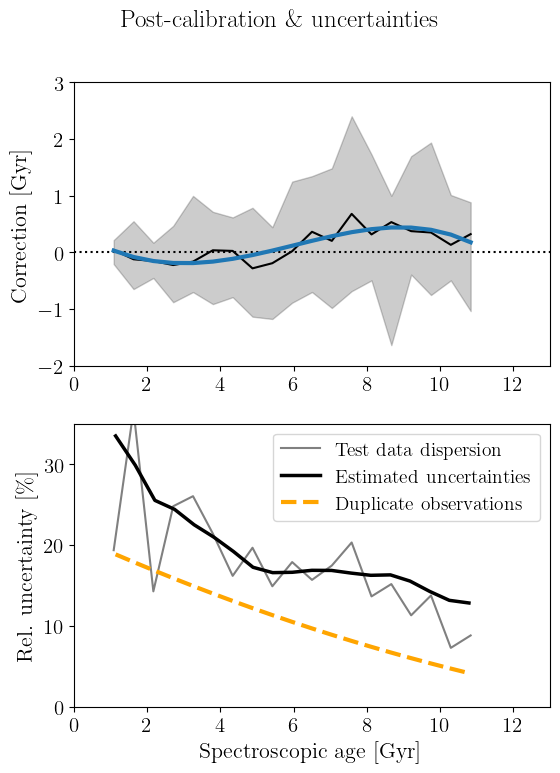

In [49]:
agebins, med, q16, q84, N = running_median(y_med, test_y-y_med, nbins=20)

f, (a0, a1) = plt.subplots(2, 1, height_ratios=[1, 1], figsize=(6,8))

plt.axes(a0)
plt.hlines(0,0,13, color="k", ls="dotted")
plt.axis([0,13,-2,3])
plt.plot(agebins, med, color="k")
plt.fill_between(agebins, q84, q16, alpha=.2, color="k")
med_fit = np.polyfit(agebins, med, 4)
p1 = np.poly1d(med_fit)
plt.plot(agebins, p1(agebins), lw=3)
plt.ylabel(r"Correction [Gyr]", fontsize=16)

plt.axes(a1)
uncert = 50.*(np.array(q84)-np.array(q16)) / np.array(agebins)
plt.plot(agebins, uncert, color="grey", label="Test data dispersion")

uncert2 = np.abs( 50.*(pred_big[:,2]-pred_big[:,0]) / pred_big[:,1] )
agebins, med2, q162, q842, N2 = running_median(pred_big[:,1], uncert2, nbins=20)
plt.plot(agebins, med2, color="k", label="Estimated uncertainties", lw=2.5)
unc_fit = np.polyfit(agebins, uncert, 2)
#p2 = np.poly1d(unc_fit)
#plt.plot(agebins, p2(agebins), lw=3, label="Adapted fit")
# Add a line for the duplicate-estimated internal uncertainties (see bottom of the notebook)
p3 = np.poly1d([ 0.04341576, -2.03895082, 21.14646907])  
plt.plot(agebins, p3(agebins), lw=3, ls="dashed", c="orange", label="Duplicate observations")
plt.axis([0,13,0,35])
plt.legend(loc="upper right", fontsize=14)
plt.xlabel(r"Spectroscopic age [Gyr]", fontsize=16)
plt.ylabel(r"Rel. uncertainty [\%]", fontsize=16)
plt.suptitle(r"Post-calibration \& uncertainties", fontsize=18)
plt.tight_layout()
plt.savefig("../im/estimating_uncertainties.png", dpi=300)

### Define columns containing the calibrated ages and uncertainties - then save this

In [50]:
def calib_func(x):
    return np.piecewise(x, [x < 1.5, (x >= 1.5) & (x < 11.5), x >= 11.5], [lambda x: 0, lambda x: p1(x), lambda x: 0])

In [59]:
save_big["spec_age"+suffix]           = np.round(pred_big[:,1], 2)
save_big["spec_age"+suffix+"_calib"]  = np.round(pred_big[:,1] + calib_func(pred_big[:,1]), 2)
save_big["spec_age"+suffix+"_sigu"]   = np.round(pred_big[:,2] - pred_big[:,1], 2) #np.round(0.01 * p2(pred_big) * pred_big, 2)
save_big["spec_age"+suffix+"_sigl"]   = np.round(pred_big[:,1] - pred_big[:,0], 2) #np.round(0.01 * p2(pred_big) * pred_big, 2)
save_big.to_csv("../data/spec_ages"+suffix+".csv")

### Have a look at the big table

In [60]:
sel_big["spec_age"+suffix]           = np.array(save_big["spec_age"+suffix])
sel_big["spec_age"+suffix+"_calib"]  = np.array(save_big["spec_age"+suffix+"_calib"])
#sel_big["spec_age"+suffix+"_uncert"] = np.array(save_big["spec_age"+suffix+"_uncert"])
sel_big["spec_age"+suffix+"_sigu"]   = np.array(save_big["spec_age"+suffix+"_sigu"])
sel_big["spec_age"+suffix+"_sigl"]   = np.array(save_big["spec_age"+suffix+"_sigl"])

In [61]:
sel_big

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,spec_age_230711,spec_age_230711_calib,spec_age_230711_sigu,spec_age_230711_sigl
8,b'2M00000133+5721163',b'apo25m',b'NGC7789_btx',b'none',0.005558,57.354549,116.014776,-4.824917,13.261,0.029,...,0.025131,2,-0.256490,-0.200830,0.132389,0,4.49,4.39,1.09,1.37
9,b'2M00000211+6327470',b'apo25m',b'117+01',b'none',0.008802,63.463078,117.227985,1.162167,11.880,0.024,...,NaN,259,0.194041,0.249701,0.070006,0,3.79,3.63,0.96,0.82
10,b'2M00000222+5625359',b'apo25m',b'N7789',b'none',0.009287,56.426662,115.831519,-5.734687,11.982,0.023,...,0.007840,2,-0.356350,-0.300690,0.131302,0,4.79,4.73,2.36,2.03
13,b'2M00000446+5854329',b'apo25m',b'116-04',b'none',0.018603,58.909149,116.330761,-3.302585,12.255,0.023,...,NaN,259,0.208779,0.264439,0.087975,0,4.08,3.94,0.82,0.66
14,b'2M00000506+5656353',b'apo25m',b'NGC7789_MGA',b'none',0.021113,56.943142,115.941040,-5.229802,9.317,0.026,...,0.009407,2,0.030740,0.086400,0.083735,0,4.06,3.92,0.41,1.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733883,b'2M23595553+6339020',b'apo25m',b'117+01',b'none',359.981416,63.650566,117.253198,1.348353,12.551,0.027,...,NaN,259,0.247312,0.302972,0.139169,0,1.10,1.10,0.62,0.22
733890,b'2M23595669+6131251',b'apo25m',b'116+00',b'none',359.986225,61.523659,116.833497,-0.736743,11.698,0.026,...,0.014083,2,-0.017480,0.038180,0.112270,0,2.73,2.54,0.52,0.51
733893,b'2M23595837+5700444',b'apo25m',b'N7789',b'none',359.993224,57.012356,115.939899,-5.158948,12.657,0.026,...,0.016774,2,-0.035640,0.020020,0.141408,0,4.31,4.19,0.68,1.05
733897,b'2M23595886+5726058',b'apo25m',b'116-04',b'none',359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,NaN,259,-0.058750,-0.003090,0.072443,0,4.87,4.82,0.35,0.56


In [63]:
print("Median age uncertainty:", np.median(0.5*(sel_big["spec_age"+suffix+"_sigu"]+sel_big["spec_age"+suffix+"_sigl"])), "Gyr")
print("Median relative age uncertainty:", np.round(50.*np.median((sel_big["spec_age"+suffix+"_sigu"]+sel_big["spec_age"+suffix+"_sigl"]) / sel_big["spec_age"+suffix+"_calib"]),1), "%")

Median age uncertainty: 1.055 Gyr
Median relative age uncertainty: 16.9 %


## Use internal cross-match to get rid of multiple APOGEE_IDs
### and then save the results

First sort by SNREV (APOGEE signal-to-noise ratio):

In [64]:
sel_big = sel_big.sort_values(by='SNREV', ascending=False)
print(np.sum(sel_big.duplicated(subset=['APOGEE_ID'])), "multiple APOGEE_IDs")

14653 multiple APOGEE_IDs


Drop the duplicates and save the table:

In [65]:
final_cat = sel_big.drop_duplicates(subset=['APOGEE_ID']).sort_index()
final_cat

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,spec_age_230711,spec_age_230711_calib,spec_age_230711_sigu,spec_age_230711_sigl
8,b'2M00000133+5721163',b'apo25m',b'NGC7789_btx',b'none',0.005558,57.354549,116.014776,-4.824917,13.261,0.029,...,0.025131,2,-0.256490,-0.200830,0.132389,0,4.49,4.39,1.09,1.37
9,b'2M00000211+6327470',b'apo25m',b'117+01',b'none',0.008802,63.463078,117.227985,1.162167,11.880,0.024,...,NaN,259,0.194041,0.249701,0.070006,0,3.79,3.63,0.96,0.82
10,b'2M00000222+5625359',b'apo25m',b'N7789',b'none',0.009287,56.426662,115.831519,-5.734687,11.982,0.023,...,0.007840,2,-0.356350,-0.300690,0.131302,0,4.79,4.73,2.36,2.03
13,b'2M00000446+5854329',b'apo25m',b'116-04',b'none',0.018603,58.909149,116.330761,-3.302585,12.255,0.023,...,NaN,259,0.208779,0.264439,0.087975,0,4.08,3.94,0.82,0.66
15,b'2M00000506+5656353',b'apo25m',b'NGC7789_btx',b'none',0.021113,56.943142,115.941040,-5.229802,9.317,0.026,...,0.009253,2,0.009090,0.064750,0.084202,0,4.12,3.99,0.58,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733883,b'2M23595553+6339020',b'apo25m',b'117+01',b'none',359.981416,63.650566,117.253198,1.348353,12.551,0.027,...,NaN,259,0.247312,0.302972,0.139169,0,1.10,1.10,0.62,0.22
733890,b'2M23595669+6131251',b'apo25m',b'116+00',b'none',359.986225,61.523659,116.833497,-0.736743,11.698,0.026,...,0.014083,2,-0.017480,0.038180,0.112270,0,2.73,2.54,0.52,0.51
733893,b'2M23595837+5700444',b'apo25m',b'N7789',b'none',359.993224,57.012356,115.939899,-5.158948,12.657,0.026,...,0.016774,2,-0.035640,0.020020,0.141408,0,4.31,4.19,0.68,1.05
733897,b'2M23595886+5726058',b'apo25m',b'116-04',b'none',359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,NaN,259,-0.058750,-0.003090,0.072443,0,4.87,4.82,0.35,0.56


## Add flags!

These things will be flagged: 
- star slightly outside the training regime
- star candidate fast rotator (using the criterion of Patton+2023)
- star is apparently young & alpha-rich

In [77]:
# 1. star slightly outside the training regime (towards the blue or red side of the main RGB/RC locus)
blue = (final_cat['LOGG'] < -8.6 + 0.0022*final_cat['TEFF'])
red  = (final_cat['LOGG'] > -7 + 0.0022*final_cat['TEFF'])
print(np.sum(blue), "stars a bit too blue")
print(np.sum(red), "stars a bit too red")
# 2. star candidate fast rotator
fast = (final_cat['VSINI'] > 10)
print(np.sum(fast), "fast rotators")
# 3. star young and alpha-rich
yar  = (final_cat["MG_FE"] > 0.2 + 0.0004*(final_cat["spec_age"+suffix+"_calib"] - 3.5)**5)
print(np.sum(yar), "young alpha-rich")

4137 stars a bit too blue
280 stars a bit too red
561 fast rotators
1222 young alpha-rich


In [103]:
# Now implement this as a string flag cloumn
final_cat["spec_age"+suffix+"_flag"] = ""
final_cat["spec_age"+suffix+"_flag"][blue] += "BLUER_THAN_TRAINING_SET "
final_cat["spec_age"+suffix+"_flag"][red]  += "REDDER_THAN_TRAINING_SET "
final_cat["spec_age"+suffix+"_flag"][fast] += "HIGH_VSINI"
final_cat["spec_age"+suffix+"_flag"][yar]  += "APPARENTLY_YOUNG_ALPHA_RICH"
# eliminate the final " " in the few relevant cases
final_cat["spec_age"+suffix+"_flag"][final_cat["spec_age"+suffix+"_flag"]=="BLUER_THAN_TRAINING_SET "]="BLUER_THAN_TRAINING_SET"
final_cat["spec_age"+suffix+"_flag"][final_cat["spec_age"+suffix+"_flag"]=="REDDER_THAN_TRAINING_SET "]="REDDER_THAN_TRAINING_SET"


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [104]:
# Visualise this column
np.unique(final_cat["spec_age"+suffix+"_flag"][final_cat["spec_age"+suffix+"_flag"]!=""])
print(len(final_cat["spec_age"+suffix+"_flag"][final_cat["spec_age"+suffix+"_flag"]!=""]), "flagged stars in total")

5549 flagged stars in total


In [105]:
save_table = Table.from_pandas(final_cat[["APOGEE_ID", 
                                          "spec_age"+suffix, "spec_age"+suffix+"_calib", 
                                          "spec_age"+suffix+"_sigl", "spec_age"+suffix+"_sigu",
                                          "spec_age"+suffix+"_flag"]])
save_table.write("../data/spec_ages"+suffix+".fits", overwrite=True)

### Estimate the method's internal uncertainty by looking at the age scatter between duplicate stars:

In [106]:
dups_last  = sel_big[["APOGEE_ID","SNREV","spec_age"+suffix]][sel_big.duplicated(subset=['APOGEE_ID'], keep="first")]
dups_first = sel_big[["APOGEE_ID","SNREV","spec_age"+suffix]][sel_big.duplicated(subset=['APOGEE_ID'], keep="last")]

dups_last  = dups_last.set_index("APOGEE_ID")
dups_first = dups_first.set_index("APOGEE_ID")

dups = dups_first.merge(dups_last, on='APOGEE_ID', suffixes=('_first', '_last'))
dups

,SNREV_first,spec_age_230711_first,SNREV_last,spec_age_230711_last
APOGEE_ID,,,,
b'2M03320729+4526557',3103.083252,5.78,939.933167,5.87
b'2M01240544+8555173',2749.270508,6.57,2195.010254,6.75
b'2M01200992+8445276',2584.540039,0.95,2085.477783,0.94
b'2M03293213+4519275',2500.585938,3.90,714.637085,4.00
b'2M06495343-0421397',2474.801758,0.88,592.658447,0.89
...,...,...,...,...
b'2M21064606+4719419',55.055466,3.36,51.802853,4.62
b'2M06262529-3142032',55.032825,2.33,54.805687,2.58
b'2M10465830-6011426',54.889824,4.02,51.074741,5.27


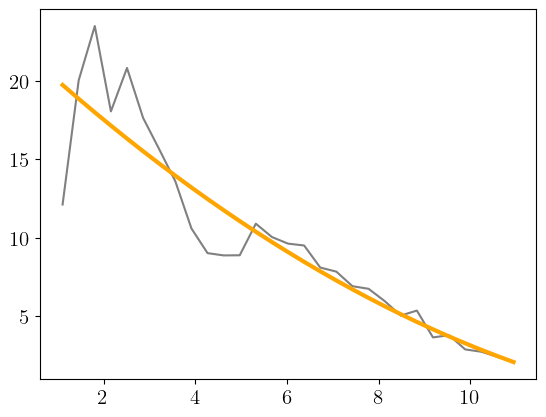

In [107]:
agebins, med, q16, q84, N = running_median(dups["spec_age"+suffix+"_first"], 
                                           dups["spec_age"+suffix+"_last"]-dups["spec_age"+suffix+"_first"], nbins=30)
uncert = 50.*(np.array(q84)-np.array(q16)) / np.array(agebins)
plt.plot(agebins, uncert, color="grey")
unc_fit = np.polyfit(agebins, uncert, 2)
p3 = np.poly1d(unc_fit)
plt.plot(agebins, p3(agebins), lw=3, c="orange")

In [108]:
p3

poly1d([ 0.07534624, -2.70341639, 22.63924834])